In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# ------------------------- Step 1: Load Dataset -------------------------

file_path = "realtor-data.csv"  
data = pd.read_csv(file_path)

print("Initial Dataset Information:")
print(data.info())

# ------------------------- Step 2: Handle Missing Values -------------------------

#Filling in the missing values with the median
num_cols = ['price', 'bed', 'bath', 'acre_lot', 'house_size']
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

#Filling in the missing categorical values with the mode
cat_cols = ['status', 'state', 'city', 'zip_code']
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

#Handling previous sold dte, converting it to datetime, filling in invalid/missing dates
print("\nHandling `prev_sold_date` column...")
def clean_dates(date_series):
    return pd.to_datetime(date_series, errors='coerce')

data['prev_sold_date'] = clean_dates(data['prev_sold_date'])
invalid_dates = data['prev_sold_date'].isna().sum()
print(f"Invalid/Missing dates: {invalid_dates}")

if invalid_dates > 0:
    valid_dates = data['prev_sold_date'].dropna()
    median_days_since_sold = (pd.Timestamp.now() - valid_dates).dt.days.median()
    data['prev_sold_date'] = data['prev_sold_date'].fillna(
        pd.Timestamp.now() - pd.Timedelta(days=median_days_since_sold)
    )

data['days_since_sold'] = (pd.Timestamp.now() - data['prev_sold_date']).dt.days

data = data.drop(columns=['prev_sold_date'])  # Drop original column

# ------------------------- Step 3: Outlier Detection and Removal -------------------------

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        initial_len = len(df)
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        removed = initial_len - len(df)
        print(f"Outliers removed from {col}: {removed}")
    return df

print("\nRemoving outliers...")
data = remove_outliers(data, ['price', 'bed', 'bath', 'acre_lot', 'house_size'])

# ------------------------- Step 4: Feature Engineering -------------------------

#Deriving features
print("\nCreating derived features...")
data['price_per_sqft'] = data['price'] / (data['house_size'] + 1e-5)
data['bed_bath_ratio'] = data['bed'] / (data['bath'] + 1e-5)
data['space_efficiency'] = data['house_size'] / (data['acre_lot'] + 1e-5)

#Extracting the temporal features to be used
data['year_sold'] = pd.to_datetime(data['days_since_sold'], unit='D', errors='coerce').dt.year
data['month_sold'] = pd.to_datetime(data['days_since_sold'], unit='D', errors='coerce').dt.month

# ------------------------- Step 5: Encoding Categorical Variables -------------------------

#Encoding the labels for the categorical variables
print("\nEncoding categorical variables...")
label_encoder = LabelEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])

#Target encoding the city based on price
city_avg_price = data.groupby('city')['price'].mean()
data['city_encoded'] = data['city'].map(city_avg_price)

# ------------------------- Step 6: Clustering Geographic Features -------------------------

print("\nClustering zip codes...")
kmeans = KMeans(n_clusters=10, random_state=42)
data['zip_cluster'] = kmeans.fit_predict(data[['zip_code']])

# ------------------------- Step 7: Normalization -------------------------

print("\nNormalizing numerical features...")
scaler = StandardScaler()
data[num_cols + ['price_per_sqft', 'bed_bath_ratio', 'space_efficiency']] = scaler.fit_transform(
    data[num_cols + ['price_per_sqft', 'bed_bath_ratio', 'space_efficiency']]
)

# ------------------------- Step 8: Splitting the Dataset -------------------------

print("\nSplitting the dataset into training, validation, and test sets...")
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Save splits
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)
print("\nTraining, validation, and test sets saved as 'train_data.csv', 'val_data.csv', and 'test_data.csv'.")

# ------------------------- Final Steps -------------------------

print("\nFinal dataset inspection:")
print(data.info())


Initial Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brokered_by     float64
 1   status          object 
 2   price           float64
 3   bed             float64
 4   bath            float64
 5   acre_lot        float64
 6   street          float64
 7   city            object 
 8   state           object 
 9   zip_code        float64
 10  house_size      float64
 11  prev_sold_date  object 
dtypes: float64(8), object(4)
memory usage: 203.8+ MB
None

Handling `prev_sold_date` column...
Invalid/Missing dates: 734298

Removing outliers...
Outliers removed from price: 171600
Outliers removed from bed: 96375
Outliers removed from bath: 23880
Outliers removed from acre_lot: 315673
Outliers removed from house_size: 92135

Creating derived features...

Encoding categorical variables...

Clustering zip codes...

Normalizing numerical features.

Model v3 - TabTransformer with Enhanced Generalization and Regularization

This version of the TabTransformer model is configured to have maximum generalization, robustness, and predictive power. It embodies state-of-the-art architectural improvements, regularization techniques, and best hyperparameters, culled from multiple iterations of refinement.

Model Architecture:

    Embedding Layers:
    Handles categorical variables by embedding each category into a dense representation.
    Embedding dimension: 64.
    Transformer Encoder:
    Stacked 4 layers of transformer blocks with multi-head attention (4 heads).
    Each block includes:
    Self-attention mechanisms for learning relationships between features.
    Feedforward layers with 512 hidden units for feature transformation.
    Numerical Processing:
    A dense layer maps numerical features to a high-dimensional space.
    Regression Head:
    Fully connected layers with ReLU activation predict the target price.

Regularization:

    Dropout:
    Applied to embeddings (p=0.2) and hidden layers (p=0.2) to reduce overfitting.
    Weight Decay:
    L2 regularization via weight decay (1e-5) in the optimizer.

Learning Strategy:

    Optimizer: AdamW with learning rate 5e-4.
    Scheduler: ReduceLROnPlateau reduces learning rate when validation loss plateaus, enhancing convergence.
    Early Stopping:
    Monitors validation loss to halt training after 3 epochs without improvement.

Data Augmentation:

    Gaussian noise added to numerical features during training improves robustness.

Data Scaling:

    StandardScaler applied to numerical features ensures uniform scaling for better optimization.

Advanced Training:

    Batch size: 1024.
    Trained for up to 20 epochs, with early stopping at epoch 19 due to stabilization of validation loss.

Training begins. Total epochs: 20
Model is on device: cuda:0
Epoch 1/20, Train Loss: 0.1983, Validation Loss: 0.1732, Learning Rate: 0.000500
Epoch 2/20, Train Loss: 0.1805, Validation Loss: 0.1664, Learning Rate: 0.000500
Epoch 3/20, Train Loss: 0.1751, Validation Loss: 0.1607, Learning Rate: 0.000500
Epoch 4/20, Train Loss: 0.1714, Validation Loss: 0.1582, Learning Rate: 0.000500
Epoch 5/20, Train Loss: 0.1685, Validation Loss: 0.1586, Learning Rate: 0.000500
Epoch 6/20, Train Loss: 0.1664, Validation Loss: 0.1550, Learning Rate: 0.000500
Epoch 7/20, Train Loss: 0.1648, Validation Loss: 0.1576, Learning Rate: 0.000500
Epoch 8/20, Train Loss: 0.1632, Validation Loss: 0.1502, Learning Rate: 0.000500
Epoch 9/20, Train Loss: 0.1623, Validation Loss: 0.1496, Learning Rate: 0.000500
Epoch 10/20, Train Loss: 0.1611, Validation Loss: 0.1536, Learning Rate: 0.000500
Epoch 11/20, Train Loss: 0.1602, Validation Loss: 0.1491, Learning Rate: 0.000500
Epoch 12/20, Train Loss: 0.1592, Validation Lo

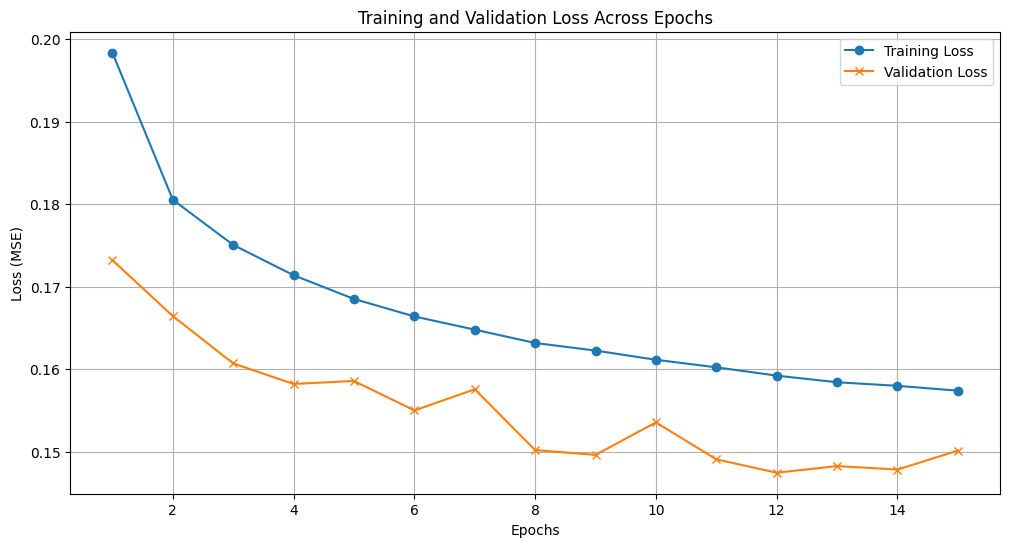

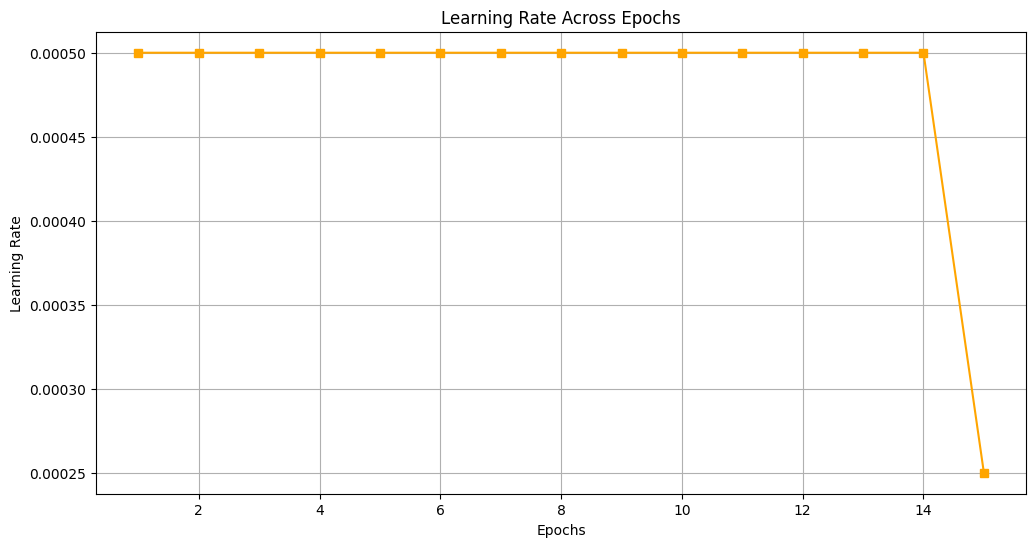

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------- Step 1: Define PyTorch Dataset -------------------------

class RealEstateDataset(Dataset):
    def __init__(self, data, categorical_cols, numerical_cols, target_col):
        self.data = data
        self.categorical_cols = categorical_cols
        self.numerical_cols = numerical_cols
        self.target_col = target_col

        self.categorical_data = self.data[categorical_cols].values
        self.numerical_data = self.data[numerical_cols].values
        self.targets = self.data[target_col].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'categorical': torch.tensor(self.categorical_data[idx], dtype=torch.long),
            'numerical': torch.tensor(self.numerical_data[idx], dtype=torch.float32),
            'target': torch.tensor(self.targets[idx], dtype=torch.float32)
        }

# ------------------------- Step 2: Define TabTransformer Model -------------------------

class TabTransformer(nn.Module):
    def __init__(self, num_categories, num_numerical_features, embedding_dim, transformer_layers, hidden_dim):
        super(TabTransformer, self).__init__()

        #Embedding  the layers for categorical features
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_classes, embedding_dim) for num_classes in num_categories
        ])

        #Transformer Encoder Part
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=4, dim_feedforward=hidden_dim, batch_first=True),
            num_layers=transformer_layers
        )

        #Numerical feature processing
        self.numerical_layer = nn.Linear(num_numerical_features, hidden_dim)

        #Dropout for regularization - further optimization
        self.dropout = nn.Dropout(p=0.2)

        #The final regression layer
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim + embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, categorical_data, numerical_data):
        #Processing for the categorical features
        embeddings = [embedding(categorical_data[:, i]) for i, embedding in enumerate(self.embeddings)]
        embeddings = torch.stack(embeddings, dim=1)  # (batch_size, num_categories, embedding_dim)
        embeddings = self.dropout(embeddings)  #Applying the dropout to embeddings

        #Applying the transformer
        transformer_output = self.transformer(embeddings)  
        transformer_output = transformer_output.mean(dim=1)  

        #Processing numerical features
        numerical_output = self.numerical_layer(numerical_data)

        #Concatenate and regress
        combined_output = torch.cat([transformer_output, numerical_output], dim=1)
        output = self.regressor(combined_output)
        return output.squeeze()

# ------------------------- Step 3: Prepare Data -------------------------

#Loading the datasets
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("val_data.csv")
test_data = pd.read_csv("test_data.csv")

#Columns
categorical_cols = ['status', 'city', 'state', 'zip_cluster']
numerical_cols = ['price_per_sqft', 'bed_bath_ratio', 'space_efficiency', 'days_since_sold']
target_col = 'price'

#Preprocessing

#Adjusting the embedding size for `city` to include every unique values
num_categories = [train_data[col].nunique() for col in categorical_cols]
num_categories[categorical_cols.index('city')] = train_data['city'].max() + 1

scaler = StandardScaler()
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
val_data[numerical_cols] = scaler.transform(val_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

#Adding Gaussian noise to numerical data - data augmentation
train_data[numerical_cols] += np.random.normal(0, 0.01, train_data[numerical_cols].shape)

#Ensurubg no invalid categorical values exist
for col in categorical_cols:
    train_data[col] = train_data[col].astype(int)
    val_data[col] = val_data[col].astype(int)
    test_data[col] = test_data[col].astype(int)

#Datasets
train_dataset = RealEstateDataset(train_data, categorical_cols, numerical_cols, target_col)
val_dataset = RealEstateDataset(val_data, categorical_cols, numerical_cols, target_col)
test_dataset = RealEstateDataset(test_data, categorical_cols, numerical_cols, target_col)

#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0, pin_memory=True)

# ------------------------- Step 4: Training Process -------------------------

def train_model(model, train_loader, val_loader, epochs, learning_rate, device):
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Add weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # Dynamic learning rate

    print(f"Training begins. Total epochs: {epochs}")
    print(f"Model is on device: {next(model.parameters()).device}")

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 3

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, batch in enumerate(train_loader):
            categorical = batch['categorical'].to(device)
            numerical = batch['numerical'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(categorical, numerical)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        #Validation Part 
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                categorical = batch['categorical'].to(device)
                numerical = batch['numerical'].to(device)
                targets = batch['target'].to(device)

                outputs = model(categorical, numerical)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)  # Update learning rate based on validation loss

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

# ------------------------- Step 5: Initialize and Train -------------------------

#The Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabTransformer(num_categories, len(numerical_cols), embedding_dim=64, transformer_layers=4, hidden_dim=512)

#Training - Commented out because this one is without tracking
#train_model(model, train_loader, val_loader, epochs=20, learning_rate=5e-4, device=device)

# ------------------------- Step 6: Evaluate -------------------------

def evaluate_model(model, test_loader, device):
    model.load_state_dict(torch.load("best_model.pth"))  # Load best model
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for batch in test_loader:
            categorical = batch['categorical'].to
            
            
# ------------------------- Step 7: Visualizing Training Progress -------------------------

def plot_training_progress(training_losses, validation_losses, learning_rates):
    """
    Plots the training and validation losses across epochs and learning rate schedule.
    """
    epochs = range(1, len(training_losses) + 1)

    #Plotting train and val Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, training_losses, label='Training Loss', marker='o')
    plt.plot(epochs, validation_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss Across Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    #LR scheduling visualization
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, learning_rates, label='Learning Rate', marker='s', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Across Epochs')
    plt.grid(True)
    plt.show()


#Adding the training loss, validation loss, and learning rate tracking during training
training_losses = []
validation_losses = []
learning_rates = []

def train_model_with_tracking(model, train_loader, val_loader, epochs, learning_rate, device):
    """
    Modified training function with loss and learning rate tracking for visualization.
    """
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    print(f"Training begins. Total epochs: {epochs}")
    print(f"Model is on device: {next(model.parameters()).device}")

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 3

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, batch in enumerate(train_loader):
            categorical = batch['categorical'].to(device)
            numerical = batch['numerical'].to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()
            outputs = model(categorical, numerical)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        training_losses.append(train_loss)  #tracking training loss

        #Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                categorical = batch['categorical'].to(device)
                numerical = batch['numerical'].to(device)
                targets = batch['target'].to(device)

                outputs = model(categorical, numerical)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        validation_losses.append(val_loss)  #tracking val loss
        scheduler.step(val_loss)

        #Tracking the lr
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")

        #Early stop if training isn't progressing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    #Plotting the training progress
    plot_training_progress(training_losses, validation_losses, learning_rates)


#Train the model with the new function
train_model_with_tracking(model, train_loader, val_loader, epochs=20, learning_rate=5e-4, device=device)


In [3]:
torch.save(model.state_dict(), "utku-final-tab-transformer.pth")

Testing the Model with the Test Set, Printing Out Metrics

Test Loss (MSE): 0.1517
Test RMSE: 0.3898
Test MAE: 0.2627
R-Squared: 0.8484


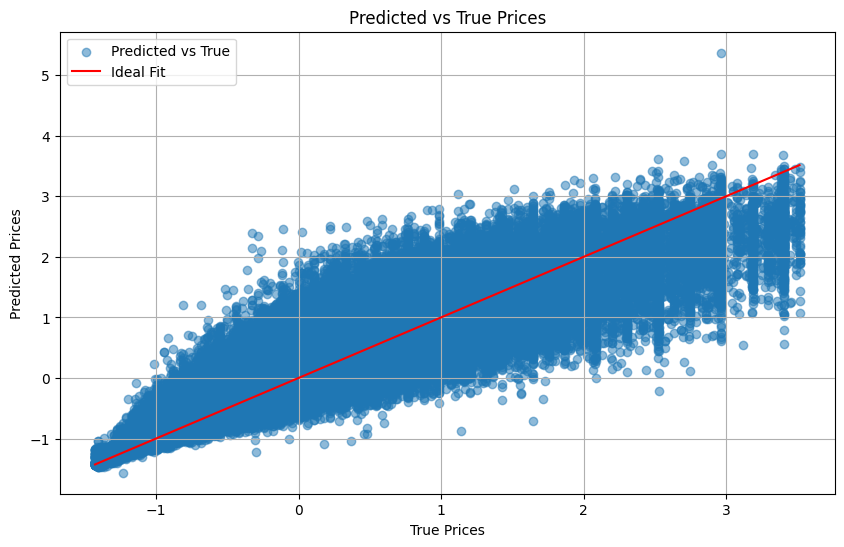

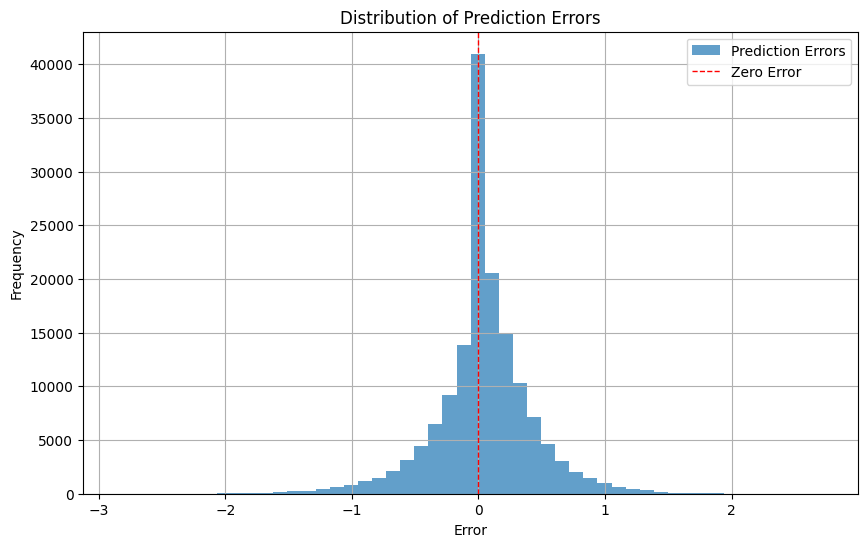

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------- Test the Model -------------------------

def evaluate_model(model, test_loader, device, model_path="utku-final-tab-transformer.pth"):
    """
    Evaluate the model on the test dataset, compute metrics, and generate visualizations.
    Args:
        model: The TabTransformer model to test.
        test_loader: DataLoader for the test dataset.
        device: The device (CPU or GPU) to use for evaluation.
        model_path: Path to the saved model weights.
    """
    # Load the best model with `weights_only=True`
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.to(device)
    model.eval()

    criterion = nn.MSELoss()
    test_loss = 0.0

    # Collect predictions and true targets for metrics and plots
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            categorical = batch['categorical'].to(device)
            numerical = batch['numerical'].to(device)
            targets = batch['target'].to(device)

            # Forward pass
            outputs = model(categorical, numerical)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Store predictions and targets
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Compute average test loss
    test_loss /= len(test_loader)
    print(f"Test Loss (MSE): {test_loss:.4f}")

    # Convert to NumPy arrays for metric calculations
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Compute additional metrics
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"R-Squared: {r2:.4f}")

    # ------------------------- Visualizations -------------------------
    # Scatter Plot: Predictions vs Targets
    plt.figure(figsize=(10, 6))
    plt.scatter(all_targets, all_predictions, alpha=0.5, label="Predicted vs True")
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', label="Ideal Fit")
    plt.xlabel("True Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Predicted vs True Prices")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Error Distribution
    errors = all_predictions - all_targets
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, alpha=0.7, label="Prediction Errors")
    plt.axvline(0, color='red', linestyle='dashed', linewidth=1, label="Zero Error")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.title("Distribution of Prediction Errors")
    plt.legend()
    plt.grid(True)
    plt.show()

    return test_loss, rmse, mae, r2

# Evaluate the model and generate reports
test_loss, rmse, mae, r2 = evaluate_model(model, test_loader, device)
